# Метрики

## Imports

In [ ]:
!pip install rectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import numba as nb

from tqdm.auto import tqdm
from rectools import Columns

In [ ]:
np.random.seed(23)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read data

In [ ]:
interactions = pd.read_csv('/content/drive/MyDrive/ИТМО/RecSys/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/ИТМО/RecSys/users.csv')
items = pd.read_csv('/content/drive/MyDrive/ИТМО/RecSys/items.csv')

In [ ]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [ ]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


Выделим небольшой кусок из данных, чтобы не слишком страдать

In [ ]:
sample_users = [57607, 403227, 70720]
df = interactions[interactions[Columns.User].isin(sample_users)].reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [ ]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)

Users [ 70720  57607 403227]
Items [ 4880  4151 10440  4881  6353  1736  6327 13865  5336   181]


## Regression

В регрессией все относительно просто. По (user, item) мы знаем таргет (рейтинг чаще всего) и по такой же паре предсказываем его

In [ ]:
df['target'] = np.random.choice([3, 4, 5], df.shape[0])
df['predict'] = np.random.rand(df.shape[0]) * 3 + 2
df

,user_id,item_id,target,predict
0,70720,4880,5,2.658958
1,57607,4151,3,4.500017
2,57607,10440,4,3.280296
3,70720,4881,5,4.263719
4,403227,6353,3,4.990597
5,403227,1736,4,2.000249
6,70720,6327,3,4.927865
7,57607,13865,5,3.257364
8,403227,5336,4,4.044672
9,403227,181,5,4.257889


Общая оценка

In [ ]:
mae = (df['target'] - df['predict']).abs().mean()
print(mae)

1.374467645324227


Оценка по пользователю с последюущим усреднением

In [ ]:
df['diff'] = (df['target'] - df['predict']).abs()
average_mae = df.groupby(Columns.User)['diff'].mean()
print(average_mae.mean())
average_mae

1.3944881931989215


user_id
57607     1.320786
70720     1.668396
403227    1.194283
Name: diff, dtype: float64

Видно, что в данном случае метрики близки к друг другу, но это не всегда так

In [ ]:
del df['target'], df['predict'], df['diff']

## Classification

Сгенерируем случайные рекомендации.

In [ ]:
top_k = 5
recs = np.array([
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
])
recs

array([[ 4880,  6327, 10440,  1736,  4881],
       [  181,  1736,  4880, 13865,  6353],
       [ 4151,  4881,  6353, 10440,  1736]])

Преобразуем в длинный датафрейм

In [ ]:
df_recs = pd.DataFrame({
    Columns.User: np.repeat(sample_users, top_k),
    Columns.Item: recs.ravel()
})
df_recs

,user_id,item_id
0,57607,4880
1,57607,6327
2,57607,10440
3,57607,1736
4,57607,4881
5,403227,181
6,403227,1736
7,403227,4880
8,403227,13865
9,403227,6353


In [ ]:
df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
headtail(df_recs)

,user_id,item_id,rank
0,57607,4880,1
1,57607,6327,2
2,57607,10440,3
3,57607,1736,4
4,57607,4881,5
10,70720,4151,1
11,70720,4881,2
12,70720,6353,3
13,70720,10440,4
14,70720,1736,5


Ключевой момент. Именно ради него преобразовывали данные и именно это позволяет считать метрики быстрее.

In [ ]:
df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
df_recs = df_recs.sort_values(by=[Columns.User, Columns.Rank])
df_recs

,user_id,item_id,rank
2,57607,10440,3.0
1,57607,4151,NaN
7,57607,13865,NaN
3,70720,4881,2.0
0,70720,4880,NaN
6,70720,6327,NaN
9,403227,181,1.0
5,403227,1736,2.0
4,403227,6353,5.0
8,403227,5336,NaN


### Precision@K

In [ ]:
df_recs[f'TP@5'] = df_recs['rank'] < 6
df_recs

,user_id,item_id,rank,TP@5
2,57607,10440,3.0,True
1,57607,4151,NaN,False
7,57607,13865,NaN,False
3,70720,4881,2.0,True
0,70720,4880,NaN,False
6,70720,6327,NaN,False
9,403227,181,1.0,True
5,403227,1736,2.0,True
4,403227,6353,5.0,True
8,403227,5336,NaN,False


In [ ]:
df_recs[df_recs[Columns.Rank].notnull()]

,user_id,item_id,rank,TP@5
2,57607,10440,3.0,True
3,70720,4881,2.0,True
9,403227,181,1.0,True
5,403227,1736,2.0,True
4,403227,6353,5.0,True


Посчитаем вручную (1/5 + 1/5 + 3/5) / 3

In [ ]:
df_recs['TP@5/5'] = df_recs['TP@5'] / top_k 

p5 = df_recs.groupby(Columns.User)['TP@5/5'].sum().mean()

print(f'Precision@5 = {p5}')

Precision@5 = 0.3333333333333333


In [ ]:
df_recs

,user_id,item_id,rank,TP@5,TP@5/5
2,57607,10440,3.0,True,0.2
1,57607,4151,NaN,False,0.0
7,57607,13865,NaN,False,0.0
3,70720,4881,2.0,True,0.2
0,70720,4880,NaN,False,0.0
6,70720,6327,NaN,False,0.0
9,403227,181,1.0,True,0.2
5,403227,1736,2.0,True,0.2
4,403227,6353,5.0,True,0.2
8,403227,5336,NaN,False,0.0


Используем тот факт, что мы знаем количество пользователей, а значит groupby не нужен

In [ ]:
p5 = df_recs['TP@5/5'].sum() / len(sample_users)
print(f'Precision@5 = {p5}')

Precision@5 = 0.3333333333333333


### Recall@K

In [ ]:
df_recs['actual'] = df_recs.groupby(Columns.User)[Columns.Item].transform('count')
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual
2,57607,10440,3.0,True,0.2,3
1,57607,4151,NaN,False,0.0,3
7,57607,13865,NaN,False,0.0,3
3,70720,4881,2.0,True,0.2,3
0,70720,4880,NaN,False,0.0,3
6,70720,6327,NaN,False,0.0,3
9,403227,181,1.0,True,0.2,4
5,403227,1736,2.0,True,0.2,4
4,403227,6353,5.0,True,0.2,4
8,403227,5336,NaN,False,0.0,4


In [ ]:
df_recs['TP@5/actual'] = df_recs['TP@5'] / df_recs['actual']
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual
2,57607,10440,3.0,True,0.2,3,0.333333
1,57607,4151,NaN,False,0.0,3,0.000000
7,57607,13865,NaN,False,0.0,3,0.000000
3,70720,4881,2.0,True,0.2,3,0.333333
0,70720,4880,NaN,False,0.0,3,0.000000
6,70720,6327,NaN,False,0.0,3,0.000000
9,403227,181,1.0,True,0.2,4,0.250000
5,403227,1736,2.0,True,0.2,4,0.250000
4,403227,6353,5.0,True,0.2,4,0.250000
8,403227,5336,NaN,False,0.0,4,0.000000


In [ ]:
(1/3 + 1/3 + 3/4) / 3

0.47222222222222215

In [ ]:
r5 = df_recs.groupby(Columns.User)['TP@5/actual'].sum().mean()
print(f'Recall@5 = {r5}')

Recall@5 = 0.47222222222222215


In [ ]:
r5 = df_recs['TP@5/actual'].sum() / len(sample_users)
print(f'Recall@5 = {r5}')

Recall@5 = 0.47222222222222215


## Ranking

### MAP@K

In [ ]:
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual
2,57607,10440,3.0,True,0.2,3,0.333333
1,57607,4151,NaN,False,0.0,3,0.000000
7,57607,13865,NaN,False,0.0,3,0.000000
3,70720,4881,2.0,True,0.2,3,0.333333
0,70720,4880,NaN,False,0.0,3,0.000000
6,70720,6327,NaN,False,0.0,3,0.000000
9,403227,181,1.0,True,0.2,4,0.250000
5,403227,1736,2.0,True,0.2,4,0.250000
4,403227,6353,5.0,True,0.2,4,0.250000
8,403227,5336,NaN,False,0.0,4,0.000000


In [ ]:
df_recs['cumTP@5'] = df_recs.groupby(Columns.User)['TP@5'].cumsum()
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual,cumTP@5
2,57607,10440,3.0,True,0.2,3,0.333333,1
1,57607,4151,NaN,False,0.0,3,0.000000,1
7,57607,13865,NaN,False,0.0,3,0.000000,1
3,70720,4881,2.0,True,0.2,3,0.333333,1
0,70720,4880,NaN,False,0.0,3,0.000000,1
6,70720,6327,NaN,False,0.0,3,0.000000,1
9,403227,181,1.0,True,0.2,4,0.250000,1
5,403227,1736,2.0,True,0.2,4,0.250000,2
4,403227,6353,5.0,True,0.2,4,0.250000,3
8,403227,5336,NaN,False,0.0,4,0.000000,3


In [ ]:
df_recs['Prec@5'] = df_recs['cumTP@5'] / df_recs[Columns.Rank]
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual,cumTP@5,Prec@5
2,57607,10440,3.0,True,0.2,3,0.333333,1,0.333333
1,57607,4151,NaN,False,0.0,3,0.000000,1,NaN
7,57607,13865,NaN,False,0.0,3,0.000000,1,NaN
3,70720,4881,2.0,True,0.2,3,0.333333,1,0.500000
0,70720,4880,NaN,False,0.0,3,0.000000,1,NaN
6,70720,6327,NaN,False,0.0,3,0.000000,1,NaN
9,403227,181,1.0,True,0.2,4,0.250000,1,1.000000
5,403227,1736,2.0,True,0.2,4,0.250000,2,1.000000
4,403227,6353,5.0,True,0.2,4,0.250000,3,0.600000
8,403227,5336,NaN,False,0.0,4,0.000000,3,NaN


In [ ]:
df_recs['Prec@5/actual'] = df_recs['Prec@5'] / df_recs['actual']
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual,cumTP@5,Prec@5,Prec@5/actual
2,57607,10440,3.0,True,0.2,3,0.333333,1,0.333333,0.111111
1,57607,4151,NaN,False,0.0,3,0.000000,1,NaN,NaN
7,57607,13865,NaN,False,0.0,3,0.000000,1,NaN,NaN
3,70720,4881,2.0,True,0.2,3,0.333333,1,0.500000,0.166667
0,70720,4880,NaN,False,0.0,3,0.000000,1,NaN,NaN
6,70720,6327,NaN,False,0.0,3,0.000000,1,NaN,NaN
9,403227,181,1.0,True,0.2,4,0.250000,1,1.000000,0.250000
5,403227,1736,2.0,True,0.2,4,0.250000,2,1.000000,0.250000
4,403227,6353,5.0,True,0.2,4,0.250000,3,0.600000,0.150000
8,403227,5336,NaN,False,0.0,4,0.000000,3,NaN,NaN


In [ ]:
ap = df_recs.groupby(Columns.User)['Prec@5/actual'].sum()
print(ap.mean())
ap

0.3092592592592593


user_id
57607     0.111111
70720     0.166667
403227    0.650000
Name: Prec@5/actual, dtype: float64

## Naive vs Numba vs Pandas

In [ ]:
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [ ]:
target = df.values
target

array([[ 70720,   4880],
       [ 57607,   4151],
       [ 57607,  10440],
       [ 70720,   4881],
       [403227,   6353],
       [403227,   1736],
       [ 70720,   6327],
       [ 57607,  13865],
       [403227,   5336],
       [403227,    181]])

In [ ]:
target[target[:, 0] == 513902][:, 1]

array([], dtype=int64)

In [ ]:
recs

array([[ 4880,  6327, 10440,  1736,  4881],
       [  181,  1736,  4880, 13865,  6353],
       [ 4151,  4881,  6353, 10440,  1736]])

In [ ]:
def precision_naive(target, users, recs, k):
    precision = []
    for i, user in enumerate(users):
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                p += 1
        precision.append(p / k)
    return sum(precision) / len(users)

In [ ]:
precision_naive(target, sample_users, recs, 5)

0.3333333333333333

In [ ]:
@nb.njit(cache=True, parallel=True)
def precision_numba(target, users, recs, k):
    precision = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                p += 1
        precision[i] = p / k
    return precision.mean()

In [ ]:
precision_numba(target, np.array(sample_users), recs, 5)

0.3333333333333333

In [ ]:
precision_numba(target, np.array(sample_users), recs, 5)

0.3333333333333333

In [ ]:
def precision_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    tp_k = f'TP@{k}'
    df_recs[tp_k] = df_recs[Columns.Rank] < (k + 1)
    p = df_recs[tp_k].sum() / k / len(users)
    return p

In [ ]:
precision_pandas(df, sample_users, recs, 5)

0.3333333333333333

Посмотрим через `timeit`

In [ ]:
%timeit precision_naive(target, sample_users, recs, 5)

143 µs ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit precision_numba(target, sample_users, recs, 5)

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'users' of function 'precision_numba'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-210-63ff3e3ecba8>", line 2:
@nb.njit(cache=True, parallel=True)
def precision_numba(target, users, recs, k):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'users' of function '__numba_parfor_gufunc_0x7f2436f12210'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File

The slowest run took 6.20 times longer than the fastest. This could mean that an intermediate result is being cached.
40.3 µs ± 40.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit precision_pandas(df, sample_users, recs, 5)

5.57 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [ ]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

In [ ]:
%timeit precision_naive(target, users, recs, top_k)

2.8 s ± 1.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
precision_numba(target, users, recs, top_k)

0.030479999999999494

In [ ]:
%timeit precision_numba(target, users, recs, top_k)

1.16 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit precision_pandas(df, users, recs, top_k)

50.5 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## RecTools

Рассмотрим, как использовать библиотеку от МТС для подсчета метрик.

Полный гайд тут - [RecTools/examples/3_metrics.ipynb](https://github.com/MobileTeleSystems/RecTools/blob/main/examples/3_metrics.ipynb)

Вначале вспомним, какие данные есть у нас

In [ ]:
df.shape, users.shape, recs.shape

((56805, 2), (10000,), (10000, 10))

In [ ]:
from rectools.metrics import Precision, Recall, MAP, calc_metrics

In [ ]:
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "MAP@5": MAP(k=5),
    "MAP@10": MAP(k=10),
}

In [ ]:
catalog = df[Columns.Item].unique()

In [ ]:
df_recs = pd.DataFrame({
    Columns.User: np.repeat(users, top_k),
    Columns.Item: recs.ravel()
})
df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1

In [ ]:
metric_values = calc_metrics(
    metrics,
    reco=df_recs,
    interactions=df,
)

In [ ]:
metric_values

{'prec@1': 0.0289,
 'prec@10': 0.03048,
 'recall@10': 0.08462718883430417,
 'MAP@5': 0.01938148253052879,
 'MAP@10': 0.026219275497237186}

Как посчитать одну метрику

In [ ]:
metrics['prec@10'].calc(df_recs, df)

0.03048

In [ ]:
%timeit metrics['prec@10'].calc(df_recs, df)

54.3 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
metrics['prec@10'].calc_per_user(df_recs, df)

user_id
24         0.0
263        0.0
477        0.0
509        0.1
522        0.0
          ... 
1097062    0.0
1097151    0.1
1097227    0.0
1097343    0.0
1097398    0.0
Length: 10000, dtype: float64

## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [ ]:
import matplotlib.pyplot as plt
import time

In [ ]:
def MRR_naive(target, users, recs, k):
    mrr = []
    for i, user in enumerate(users):
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:                
                ranku = np.argwhere(user_target == rec)[0][0] + 1
                mrr.append(1/ranku)
                break
    return sum(mrr) / len(users)


@nb.njit(cache=True, parallel=True)
def MRR_numba(target, users, recs, k):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                ranku = np.argwhere(user_target==rec)[0][0] + 1
                mrr[i] = 1 / ranku
                break
    return mrr.mean()


def MRR_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df[Columns.Rank] = df.groupby(Columns.User).cumcount() + 1
    df_recs['id'] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='inner', left_on=Columns.UserItem, right_on=Columns.UserItem)
    df_recs = df_recs.sort_values(by='id').drop_duplicates(subset='user_id', keep="first")
    df_recs['tp_k'] = 1 / df_recs['rank']
    mrr = df_recs['tp_k'].sum() / len(users)
    return mrr


def add_df(df, method, method_name, target, users, recs, k):
    start_time = time.time()
    MRR = method(target, users, recs, k)
    t = time.time() - start_time
    df = df.append({'users_count' : u, 
                    'top_k' : k, 
                    'method' : method_name,
                    'time' : t}, ignore_index = True)
    return df


users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

df_viz = pd.DataFrame(columns = ['users_count', 'top_k', 'method', 'time'])

for u in users_count:
    for k in top_k:
        df, users, recs = generate_subsample(u, k)
        target = df.values

        df_viz = add_df(df_viz, MRR_naive, 'naive', target, users, recs, k)
        df_viz = add_df(df_viz, MRR_numba, 'numba', target, users, recs, k)
        df_viz = add_df(df_viz, MRR_pandas, 'pandas', df, users, recs, k)

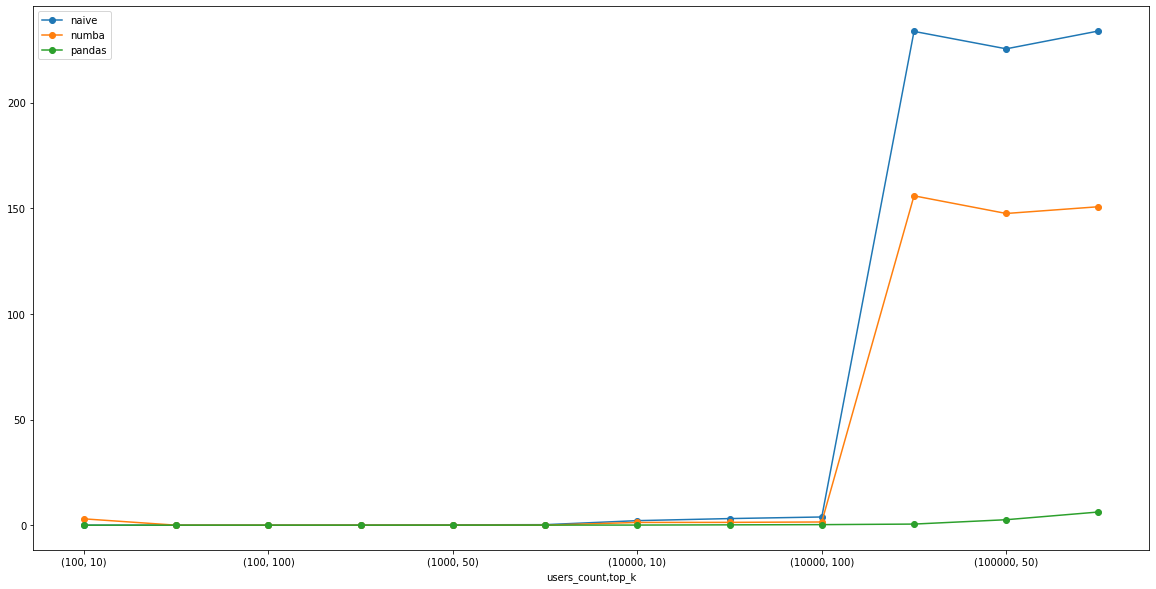

In [ ]:
plt.figure(figsize=(20,10))
df_viz.loc[df_viz['method']=='naive'].set_index(['users_count','top_k'])['time'].plot(marker='o', label='naive')
df_viz.loc[df_viz['method']=='numba'].set_index(['users_count','top_k'])['time'].plot(marker='o', label='numba')
df_viz.loc[df_viz['method']=='pandas'].set_index(['users_count','top_k'])['time'].plot(marker='o', label='pandas')

plt.legend()
plt.show()